In [2]:
pip install ncps

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.1 MB/s eta 0:00:00


Mounted at /content/drive
Epoch 1/20
45/45 [==============================] - ETA: 0s - loss: 0.0164 - mae: 0.0943
Epoch 1: val_loss improved from inf to 0.01427, saving model to best_model_with_ncp.keras
45/45 [==============================] - 26s 392ms/step - loss: 0.0164 - mae: 0.0943 - val_loss: 0.0143 - val_mae: 0.0832
Epoch 2/20
45/45 [==============================] - ETA: 0s - loss: 0.0146 - mae: 0.0825
Epoch 2: val_loss improved from 0.01427 to 0.01397, saving model to best_model_with_ncp.keras
45/45 [==============================] - 18s 393ms/step - loss: 0.0146 - mae: 0.0825 - val_loss: 0.0140 - val_mae: 0.0753
Epoch 3/20
45/45 [==============================] - ETA: 0s - loss: 0.0146 - mae: 0.0827
Epoch 3: val_loss improved from 0.01397 to 0.01387, saving model to best_model_with_ncp.keras
45/45 [==============================] - 17s 379ms/step - loss: 0.0146 - mae: 0.0827 - val_loss: 0.0139 - val_mae: 0.0746
Epoch 4/20
45/45 [==============================] - ETA: 0s - l

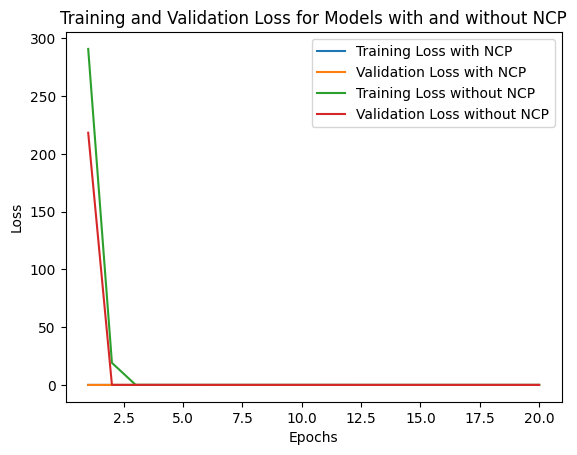

Comparison Results:
Training time with NCP: 390.29 seconds
Training time without NCP: 326.77 seconds
Model complexity (parameters) with NCP: 1782873
Model complexity (parameters) without NCP: 1774529
Additional Metrics:
Training Loss with NCP: 0.014622736722230911
Validation Loss with NCP: 0.013897052966058254
Training Loss without NCP: 0.01428248081356287
Validation Loss without NCP: 0.014512534253299236


In [3]:
import os
import time
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Reshape, BatchNormalization, Conv2D, MaxPool2D, Flatten, Dense, TimeDistributed
from sklearn.model_selection import train_test_split
from scipy import stats
from ncps.tf import LTC
from ncps.wirings import AutoNCP
from tensorflow.keras.callbacks import ModelCheckpoint
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Function to scale input data
def scaled_in(matrix_spec):
    "Global scaling applied to noisy voice spectrograms (scale between -1 and 1)"
    return (matrix_spec + 46) / 50

# Function to scale output data
def scaled_ou(matrix_spec):
    "Global scaling applied to noise models spectrograms (scale between -1 and 1)"
    return (matrix_spec - 6) / 82

# Load data
path_save_spectrogram = '/content/drive/MyDrive/npy/'  # Specify the path to the spectrogram directory

X_in = np.load(os.path.join(path_save_spectrogram, 'noisy_voice_amp_db.npy'))
X_ou = np.load(os.path.join(path_save_spectrogram, 'voice_amp_db.npy'))

# Model of noise to predict
X_ou = X_in - X_ou

# Scale input and output data
X_in = scaled_in(X_in)
X_ou = scaled_ou(X_ou)

# Split data into train and validation sets
x_train, x_val, y_train, y_val = train_test_split(X_in, X_ou, test_size=0.10, random_state=42)

# Reshape input data to include the time dimension
x_train_reshaped = x_train.reshape((x_train.shape[0], 1, x_train.shape[1], x_train.shape[2], 1))
x_val_reshaped = x_val.reshape((x_val.shape[0], 1, x_val.shape[1], x_val.shape[2], 1))

y_train_reshaped = y_train.reshape((y_train.shape[0], 1, -1))
y_val_reshaped = y_val.reshape((y_val.shape[0], 1, -1))

# Define model with NCP layer
def build_rnn_model_with_ncp(input_shape):
    ncp = LTC(AutoNCP(32, output_size=8), return_sequences=True)
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(None, *input_shape)),
        TimeDistributed(Conv2D(32, (5, 5), activation="relu")),
        TimeDistributed(MaxPool2D()),
        TimeDistributed(Conv2D(64, (5, 5), activation="relu")),
        TimeDistributed(MaxPool2D()),
        TimeDistributed(Flatten()),
        TimeDistributed(Dense(32, activation="relu")),
        ncp,
        TimeDistributed(Dense(1))  # Single output unit without activation
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(0.01),
        loss='mse',
        metrics=['mae']
    )
    return model

# Define model without NCP layer
def build_rnn_model_without_ncp(input_shape):
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(None, *input_shape)),
        TimeDistributed(Conv2D(32, (5, 5), activation="relu")),
        TimeDistributed(MaxPool2D()),
        TimeDistributed(Conv2D(64, (5, 5), activation="relu")),
        TimeDistributed(MaxPool2D()),
        TimeDistributed(Flatten()),
        TimeDistributed(Dense(32, activation="relu")),
        TimeDistributed(Dense(1))  # Single output unit without activation
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(0.01),
        loss='mse',
        metrics=['mae']
    )
    return model

# Build the models
input_shape = (128, 128, 1)

rnn_model_with_ncp = build_rnn_model_with_ncp(input_shape)
rnn_model_without_ncp = build_rnn_model_without_ncp(input_shape)

# Define ModelCheckpoint for each model
checkpoint_with_ncp = ModelCheckpoint('best_model_with_ncp.keras', save_best_only=True, monitor='val_loss', verbose=1)
checkpoint_without_ncp = ModelCheckpoint('best_model_without_ncp.keras', save_best_only=True, monitor='val_loss', verbose=1)

# Train the model with NCP
start_time_with_ncp = time.time()  # Record training start time
history_with_ncp = rnn_model_with_ncp.fit(
    x_train_reshaped, y_train_reshaped,
    validation_data=(x_val_reshaped, y_val_reshaped),
    epochs=20,
    batch_size=10,
    verbose=1,
    callbacks=[checkpoint_with_ncp]
)
training_time_with_ncp = time.time() - start_time_with_ncp  # Calculate total training time

# Train the model without NCP
start_time_without_ncp = time.time()  # Record training start time
history_without_ncp = rnn_model_without_ncp.fit(
    x_train_reshaped, y_train_reshaped,
    validation_data=(x_val_reshaped, y_val_reshaped),
    epochs=20,
    batch_size=10,
    verbose=1,
    callbacks=[checkpoint_without_ncp]
)
training_time_without_ncp = time.time() - start_time_without_ncp  # Calculate total training time

# Compare performance
import matplotlib.pyplot as plt

# Plot training and validation loss for both models
epochs = range(1, 21)

plt.plot(epochs, history_with_ncp.history['loss'], label='Training Loss with NCP')
plt.plot(epochs, history_with_ncp.history['val_loss'], label='Validation Loss with NCP')
plt.plot(epochs, history_without_ncp.history['loss'], label='Training Loss without NCP')
plt.plot(epochs, history_without_ncp.history['val_loss'], label='Validation Loss without NCP')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for Models with and without NCP')
plt.legend()
plt.show()

# Compare training time and model complexity
params_with_ncp = rnn_model_with_ncp.count_params()
params_without_ncp = rnn_model_without_ncp.count_params()

print("Comparison Results:")
print(f"Training time with NCP: {training_time_with_ncp:.2f} seconds")
print(f"Training time without NCP: {training_time_without_ncp:.2f} seconds")
print(f"Model complexity (parameters) with NCP: {params_with_ncp}")
print(f"Model complexity (parameters) without NCP: {params_without_ncp}")

# Additional metrics for comparison
print("Additional Metrics:")
print("Training Loss with NCP:", history_with_ncp.history['loss'][-1])
print("Validation Loss with NCP:", history_with_ncp.history['val_loss'][-1])
print("Training Loss without NCP:", history_without_ncp.history['loss'][-1])
print("Validation Loss without NCP:", history_without_ncp.history['val_loss'][-1])
